In [1]:
import zipfile
import os
import tempfile

import pandas as pd
import streamlit as st
import matplotlib.pyplot as plt

from IPython.display import display, Markdown
from IPython.display import display, Markdown
from io import BytesIO
from PIL import Image
from io import BytesIO
from typing import Tuple
from codigos_hidro import indice_spi, calculo_precipitacoes, problema_inverso_idf


In [2]:
def processar_zip(uploaded_zip_bytes):
    with tempfile.TemporaryDirectory() as tmpdir:
        zip_path = os.path.join(tmpdir, "uploaded.zip")
        with open(zip_path, "wb") as f:
            f.write(uploaded_zip_bytes.read())

        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(tmpdir)

        folders = [f for f in os.scandir(tmpdir) if f.is_dir()]
        folder_path = folders[0].path if folders else tmpdir

        files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
        resumo = []
        planilhas_completas = {}

        for file in files:
            file_path = os.path.join(folder_path, file)
            try:
                with open(file_path, encoding='utf-8') as f:
                    linhas = [next(f).strip() for _ in range(9)]

                cabecalho = {}
                for linha in linhas:
                    if ':' in linha:
                        chave, valor = linha.split(':', 1)
                        cabecalho[chave.strip().lower().replace(' ', '_')] = valor.strip()

                df_dados = pd.read_csv(file_path, sep=";", encoding="utf-8", skiprows=9)
                cod = cabecalho.get("codigo_estacao", file)
                planilhas_completas[cod] = df_dados

                total_linhas = len(df_dados)
                def calc_falha_percent(col):
                    return (df_dados[col].isna().sum() / total_linhas * 100) if col in df_dados.columns else None

                resumo.append({
                    "arquivo": file,
                    "nome": cabecalho.get("nome", ""),
                    "codigo_estacao": cabecalho.get("codigo_estacao", ""),
                    "latitude": float(cabecalho.get("latitude", 0)),
                    "longitude": float(cabecalho.get("longitude", 0)),
                    "altitude": float(cabecalho.get("altitude", 0)),
                    "situacao": cabecalho.get("situacao", ""),
                    "data_inicial": cabecalho.get("data_inicial", ""),
                    "data_final": cabecalho.get("data_final", ""),
                    "falha de precipitação (%)": calc_falha_percent("PRECIPITACAO TOTAL, DIARIO (AUT)(mm)"),
                    "falha de temperatura média (%)": calc_falha_percent("TEMPERATURA MEDIA, DIARIA (AUT)(°C)"),
                    "falha de umidade relativa (%)": calc_falha_percent("UMIDADE RELATIVA DO AR, MEDIA DIARIA (AUT)(%)"),
                    "falha de velocidade do vento (%)": calc_falha_percent("VENTO, VELOCIDADE MEDIA DIARIA (AUT)(m/s)")
                })
            except Exception as e:
                st.error(f"Erro ao processar {file}: {e}")

        df_resumo = pd.DataFrame(resumo)
        return df_resumo, planilhas_completas, os.path.basename(folder_path)
    


caminho_fixo = "./BD/$2a$10$1Q7uCy08zprNmqdl7gMruyzbBQbUtSWFu0RZ6Tu1Mb5RElg2u...zip"
with open(caminho_fixo, "rb") as f:
    uploaded_zip = BytesIO(f.read()) 

if uploaded_zip:
    df_resumo, planilhas_completas, nome_pasta = processar_zip(uploaded_zip)

planilhas_completas

{'A001':      Data Medicao  PRECIPITACAO TOTAL, DIARIO (AUT)(mm)  \
 0      2000-05-06                                   NaN   
 1      2000-05-07                                   NaN   
 2      2000-05-08                                   0.0   
 3      2000-05-09                                   0.0   
 4      2000-05-10                                   0.0   
 ...           ...                                   ...   
 9116   2025-04-21                                   0.0   
 9117   2025-04-22                                   0.0   
 9118   2025-04-23                                   0.2   
 9119   2025-04-24                                   0.0   
 9120   2025-04-25                                   0.0   
 
       TEMPERATURA MEDIA, DIARIA (AUT)(°C)  \
 0                                     NaN   
 1                                     NaN   
 2                                    22.1   
 3                                    22.1   
 4                                    22

In [3]:
def exportar_dados_por_estacao(df_resumo: pd.DataFrame, planilhas_completas: dict, codigos_estacoes: list)-> None:
    """
    Exibe os DataFrames das estações selecionadas.
    
    :param df_resumo: DataFrame contendo o resumo das estações, incluindo 'codigo_estacao' e 'nome'.
    :param planilhas_completas: Dicionário com os DataFrames das estações, indexado por código da estação.
    :param codigos_estacoes: Lista com os códigos das estações a serem exibidas (ex: ["A001", "A003"]).

    :return: None
    """
    from IPython.display import display, Markdown

    codigos_disponiveis = df_resumo["codigo_estacao"].unique().tolist()
    codigos_validos = [cod for cod in codigos_estacoes if cod in codigos_disponiveis]

    if not codigos_validos:
        print("Nenhum código de estação válido informado.")
        return

    for cod_estacao in codigos_validos:
        nome = df_resumo.loc[df_resumo["codigo_estacao"] == cod_estacao, "nome"].values[0]
        df = planilhas_completas.get(cod_estacao)

        if df is not None:
            df = df.loc[:, ~df.columns.str.contains("^Unnamed")]
            display(Markdown(f"### {nome} ({cod_estacao})"))
            display(df)
        else:
            display(Markdown(f"Dados da estação `{cod_estacao}` não encontrados em `planilhas_completas`."))



codigos = ["A001", "A003"]
exportar_dados_por_estacao(df_resumo, planilhas_completas, codigos)

### BRASILIA (A001)

,Data Medicao,"PRECIPITACAO TOTAL, DIARIO (AUT)(mm)","TEMPERATURA MEDIA, DIARIA (AUT)(°C)","UMIDADE RELATIVA DO AR, MEDIA DIARIA (AUT)(%)","VENTO, VELOCIDADE MEDIA DIARIA (AUT)(m/s)"
0,2000-05-06,NaN,NaN,NaN,NaN
1,2000-05-07,NaN,NaN,49.2,NaN
2,2000-05-08,0.0,22.1,60.3,2.1
3,2000-05-09,0.0,22.1,58.8,1.2
4,2000-05-10,0.0,22.4,62.1,2.1
...,...,...,...,...,...
9116,2025-04-21,0.0,22.5,77.0,1.2
9117,2025-04-22,0.0,21.9,81.2,1.5
9118,2025-04-23,0.2,22.6,79.1,1.7
9119,2025-04-24,0.0,22.9,75.0,2.0


### MORRINHOS (A003)

,Data Medicao,"PRECIPITACAO TOTAL, DIARIO (AUT)(mm)","TEMPERATURA MEDIA, DIARIA (AUT)(°C)","UMIDADE RELATIVA DO AR, MEDIA DIARIA (AUT)(%)","VENTO, VELOCIDADE MEDIA DIARIA (AUT)(m/s)"
0,2001-05-24,NaN,NaN,NaN,NaN
1,2001-05-25,NaN,NaN,NaN,NaN
2,2001-05-26,NaN,NaN,NaN,NaN
3,2001-05-27,NaN,NaN,NaN,NaN
4,2001-05-28,NaN,NaN,NaN,NaN
...,...,...,...,...,...
8733,2025-04-21,0.2,23.8,75.9,0.7
8734,2025-04-22,0.0,23.6,79.1,0.6
8735,2025-04-23,1.8,22.9,83.2,1.1
8736,2025-04-24,47.6,23.7,82.4,1.0


## SPI — BRASILIA (A001)

**Estatísticas SPI:**

,Mês,Média Mensal,q (zeros),Alpha (shape),Beta (scale)
0,1,199.720,0.00,4.402188,45.368351
1,2,171.192,0.00,3.197995,53.531036
2,3,188.616,0.00,5.051137,37.341298
3,4,133.624,0.00,1.869484,71.476398
4,5,21.168,0.12,1.076546,22.344184
5,6,3.048,0.60,1.337032,5.699190
6,7,1.104,0.68,0.493177,6.995454
7,8,12.496,0.56,2.526687,11.240017
8,9,30.272,0.16,2.511064,14.351725
9,10,129.768,0.00,1.498149,86.618900


**SPI Mensal:**

,AnoMes,PrecipitaçãoMensal,SPI
0,2000-05,0.0,-1.648124
1,2000-06,0.0,-1.077953
2,2000-07,0.2,0.126896
3,2000-08,52.6,1.330731
4,2000-09,50.0,0.604401
...,...,...,...
295,2024-12,214.6,-0.639487
296,2025-01,192.8,1.463601
297,2025-02,103.6,0.990080
298,2025-03,120.8,-1.031141


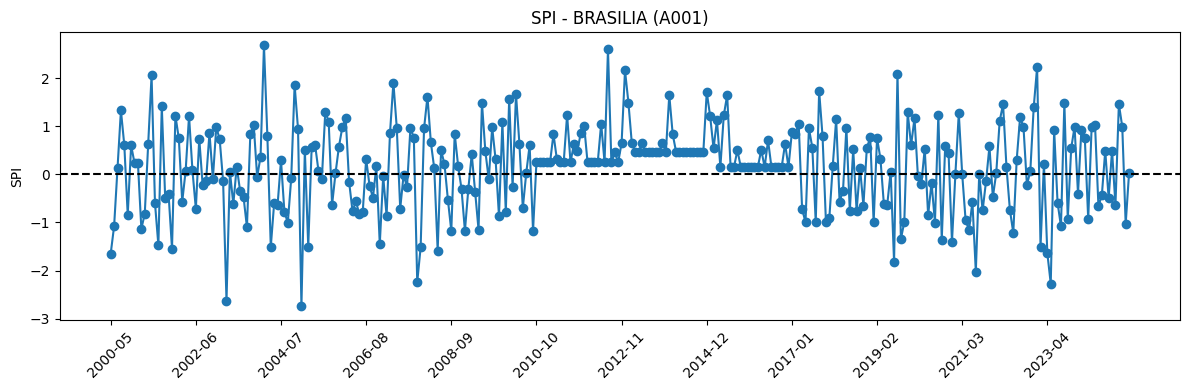

## SPI — MORRINHOS (A003)

**Estatísticas SPI:**

,Mês,Média Mensal,q (zeros),Alpha (shape),Beta (scale)
0,1,203.371429,0.000000,2.683630,75.782216
1,2,177.660000,0.000000,3.456499,51.398825
2,3,181.530000,0.050000,3.752833,50.917328
3,4,79.820000,0.050000,2.187926,38.402152
4,5,17.723810,0.095238,0.657071,29.813345
5,6,5.900000,0.454545,0.644260,16.789288
6,7,2.890909,0.590909,0.383517,18.425935
7,8,4.400000,0.476190,1.131922,7.421008
8,9,28.895238,0.142857,0.853204,39.511206
9,10,92.619048,0.000000,1.267416,73.077079


**SPI Mensal:**

,AnoMes,PrecipitaçãoMensal,SPI
0,2001-05,0.0,-0.064792
1,2001-06,2.0,0.601326
2,2001-07,0.0,0.074081
3,2001-08,21.4,1.340696
4,2001-09,102.4,1.085435
...,...,...,...
246,2024-12,307.4,0.483588
247,2025-01,196.8,-0.593178
248,2025-02,130.2,1.437639
249,2025-03,137.8,-1.291482


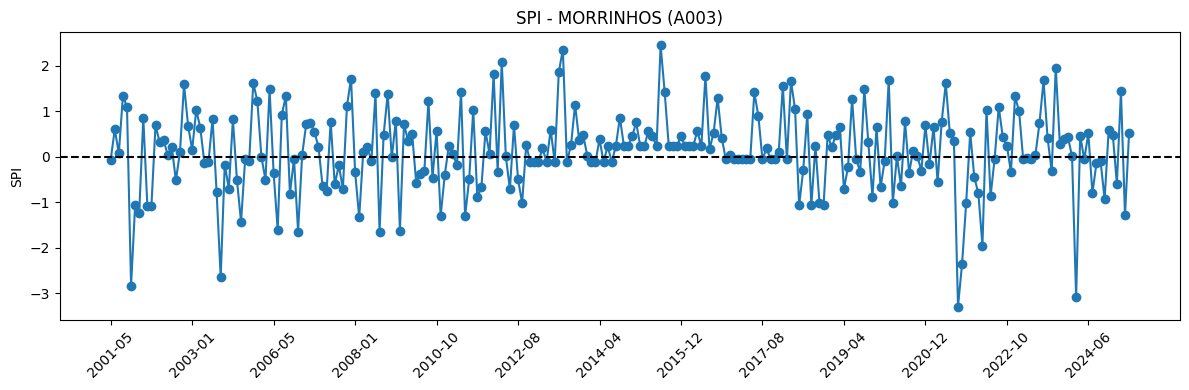

In [4]:
def calcular_spi(df_estacao: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Extrai as colunas corretas de data e precipitação do DataFrame da estação,
    renomeia para 'Data' e 'Precipitacao', e executa o cálculo do SPI.

    :param df_estacao: DataFrame original da estação, com colunas contendo 'data' e 'precip'.

    :return: 
    
        - df_spi: DataFrame com SPI mensal.
        - estatisticas_spi: DataFrame com estatísticas agregadas.
    """
    col_data = next((col for col in df_estacao.columns if "data" in col.lower()), None)
    col_precip = next((col for col in df_estacao.columns if "precip" in col.lower()), None)

    if col_data is None or col_precip is None:
        raise ValueError("Coluna de data ou precipitação não encontrada.")

    df_spi = df_estacao[[col_data, col_precip]].copy()
    df_spi.columns = ['Data', 'Precipitacao']

    return indice_spi(df_spi)


def exportar_spi(df_resumo: pd.DataFrame, planilhas_completas: dict, codigos_estacoes: list, calcular_spi: callable) -> None:
    """
    Exibe o SPI mensal e as estatísticas SPI para as estações selecionadas.

    :param df_resumo: DataFrame contendo o resumo das estações, incluindo 'codigo_estacao' e 'nome'.
    :param planilhas_completas: Dicionário com os DataFrames das estações, indexado por código da estação.
    :param codigos_estacoes: Lista com os códigos das estações a serem exibidas (ex: ["A001", "A003"]).
    :param calcular_spi: Função para calcular o SPI.

    :return: None
    """
    codigos_disponiveis = df_resumo["codigo_estacao"].unique().tolist()
    codigos_validos = [cod for cod in codigos_estacoes if cod in codigos_disponiveis]

    if not codigos_validos:
        print("Nenhum código de estação válido informado.")
        return

    for cod_estacao in codigos_validos:
        nome = df_resumo.loc[df_resumo["codigo_estacao"] == cod_estacao, "nome"].values[0]
        df = planilhas_completas.get(cod_estacao)

        if df is None:
            display(Markdown(f"Estação `{cod_estacao}` não encontrada em `planilhas_completas`."))
            continue

        display(Markdown(f"## SPI — {nome} ({cod_estacao})"))

        try:
            df_spi, estatisticas_spi = calcular_spi(df.copy())

            display(Markdown("**Estatísticas SPI:**"))
            display(estatisticas_spi)

            display(Markdown("**SPI Mensal:**"))
            display(df_spi)

            fig, ax = plt.subplots(figsize=(12, 4))
            ax.plot(df_spi["AnoMes"].astype(str), df_spi["SPI"], marker="o")
            ax.axhline(0, color="black", linestyle="--")
            ax.set_title(f"SPI - {nome} ({cod_estacao})")
            ax.set_ylabel("SPI")
            ax.set_xticks(range(0, len(df_spi), max(1, len(df_spi) // 12)))
            ax.set_xticklabels(df_spi["AnoMes"].astype(str)[::max(1, len(df_spi) // 12)], rotation=45)
            fig.tight_layout()

            buffer_spi = BytesIO()
            fig.savefig(buffer_spi, format='png', bbox_inches='tight')
            buffer_spi.seek(0)
            spi_image = Image.open(buffer_spi)
            display(spi_image)
            plt.close(fig)

        except Exception as e:
            display(Markdown(f"Erro ao calcular SPI para `{cod_estacao}`: {e}"))


codigos = ["A001", "A003"]
exportar_spi(df_resumo, planilhas_completas, codigos, calcular_spi)


In [6]:
def calcular_idf(df_estacao: pd.DataFrame) -> Tuple[Tuple[None, None, None, pd.DataFrame, None, None], Tuple[float, float, float, float]]:
    """
    Executa o cálculo completo do IDF e retorna os parâmetros ajustados.

    :param df_estacao: DataFrame contendo os dados da estação.

    :return: Uma tupla contendo:

        - df_longo: DataFrame com os dados de precipitação ajustados.
        - Parâmetros a, b, c, d do modelo IDF ajustado.
    """
    hmax_df, preciptacao_df, intensidade_df, df_longo, media, desvio = calculo_precipitacoes(df_estacao)
    a, b, c, d = problema_inverso_idf(df_longo)
    return (_, _, _, df_longo, _, _), (a, b, c, d) 

def exportar_idf(df_resumo: pd.DataFrame, planilhas_completas: dict, codigos_estacoes: list, calcular_idf: callable) -> None:
    """
    Exibe os parâmetros IDF ajustados para as estações selecionadas.

    :param df_resumo: DataFrame contendo o resumo das estações, incluindo 'codigo_estacao' e 'nome'.
    :param planilhas_completas: Dicionário com os DataFrames das estações, indexado por código da estação.
    :param codigos_estacoes: Lista com os códigos das estações a serem exibidas (ex: ["A001", "A003"]).
    :param calcular_idf: Função para calcular o IDF.

    :return: None
    """
    codigos_disponiveis = df_resumo["codigo_estacao"].unique().tolist()
    codigos_validos = [cod for cod in codigos_estacoes if cod in codigos_disponiveis]

    if not codigos_validos:
        print("Nenhum código de estação válido informado.")
        return

    for cod_estacao in codigos_validos:
        nome = df_resumo.loc[df_resumo["codigo_estacao"] == cod_estacao, "nome"].values[0]
        df = planilhas_completas.get(cod_estacao)

        if df is None:
            display(Markdown(f"Estação `{cod_estacao}` não encontrada em `planilhas_completas`."))
            continue

        try:
            (_, _, _, df_longo, _, _), (a, b, c, d) = calcular_idf(df.copy())

            display(Markdown(f"""**Parâmetros IDF ajustados para {nome} ({cod_estacao}):**  
            
```text
a = {a:.6f}  
b = {b:.6f}  
c = {c:.6f}  
d = {d:.6f}
```"""))

        except Exception as e:
            display(Markdown(f"Erro ao calcular IDF para `{cod_estacao}`: {e}"))

codigos = ["A001", "A003"]
exportar_idf(df_resumo, planilhas_completas, codigos, calcular_idf)

**Parâmetros IDF ajustados para BRASILIA (A001):**  

```text
a = 3.777444  
b = 0.340412  
c = -3.929249  
d = -0.310277
```

**Parâmetros IDF ajustados para MORRINHOS (A003):**  

```text
a = 5.179209  
b = 0.351101  
c = -3.929364  
d = -0.310276
```